In [2]:
#Importing relative libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.graphics.tsaplots as sgt
from math import sqrt
import seaborn as sns
sns.set()

In [3]:
raw_csv_data = pd.read_csv('013 IndexE81.csv')

In [4]:
data = raw_csv_data.copy()

In [5]:
data.head()

,date,spx,dax,ftse,nikkei
0,07/01/1994,469.90,2224.95,3445.98,18124.01
1,10/01/1994,475.27,2225.00,3440.58,18443.44
2,11/01/1994,474.13,2228.10,3413.77,18485.25
3,12/01/1994,474.17,2182.06,3372.02,18793.88
4,13/01/1994,472.47,2142.37,3360.01,18577.26


In [6]:
data.date = pd.to_datetime(data.date, dayfirst=True)

In [7]:
data.set_index('date', inplace=True)

In [8]:
data.head()

,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [9]:
data = data.fillna(method='ffill')
data.isnull().sum()

spx       0
dax       0
ftse      0
nikkei    0
dtype: int64

In [10]:
data['price'] = data.nikkei

In [11]:
del data['spx']
del data['dax']
del data['nikkei']
del data['ftse']
data.head()

,price
date,
1994-01-07,18124.01
1994-01-10,18443.44
1994-01-11,18485.25
1994-01-12,18793.88
1994-01-13,18577.26


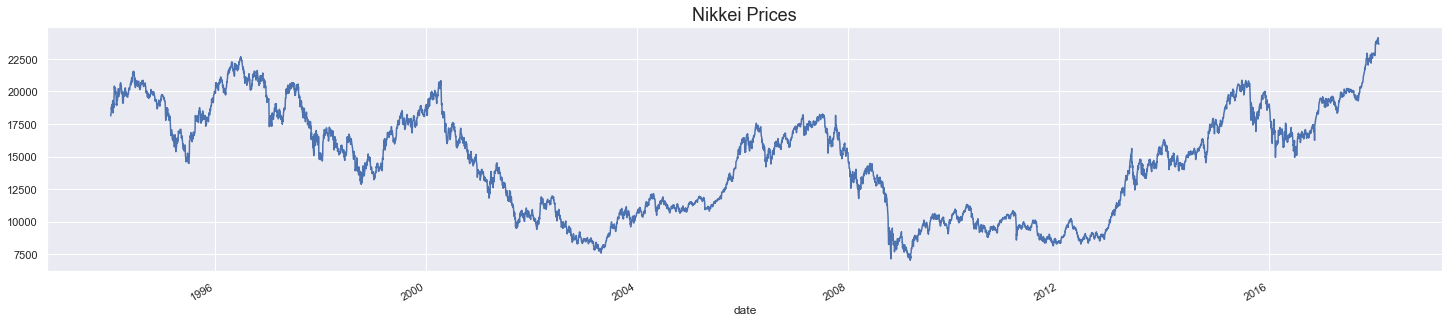

In [12]:
data.price.plot(figsize=(25,5))
plt.title('Nikkei Prices', size=18)
plt.show()

In [13]:
#Filtering Warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
size = int(len(data)*0.8)
train_data, test_data = data[size:], data[:size]

In [16]:
#ADFULLER TEST
sts.adfuller(test_data.price)

(-1.7719741965052447,
 0.39446179017391786,
 2,
 5012,
 {'1%': -3.431655397510801,
  '5%': -2.862116844845668,
  '10%': -2.567077055158601},
 66655.86848502669)

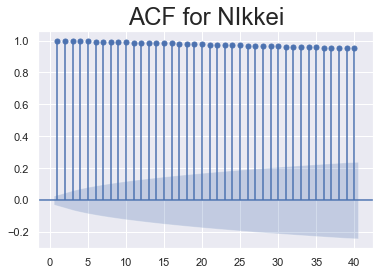

In [19]:
sgt.plot_acf(test_data.price, zero=False, lags=40)
plt.title('ACF for NIkkei', Size=24)
plt.show()

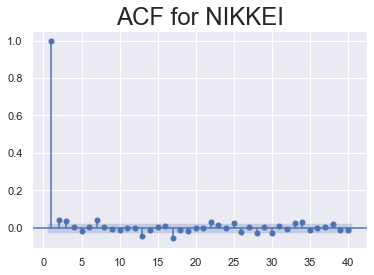

In [20]:
sgt.plot_pacf(test_data.price, zero=False, lags=40)
plt.title('ACF for NIKKEI', Size=24)
plt.show()

In [21]:
#Returns of Dax
test_data['returns'] = test_data.price.pct_change(1) * 100

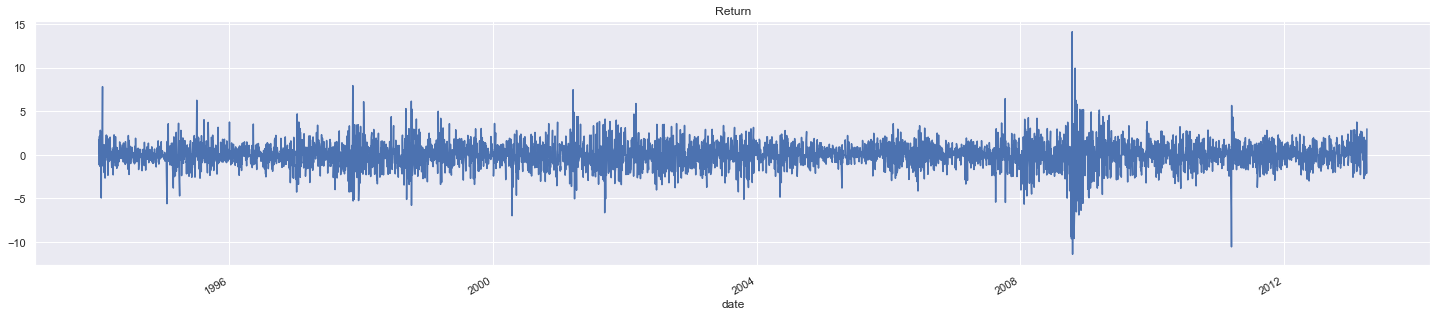

In [23]:
test_data.returns[1:].plot(figsize=(25,5))
plt.title('Return')
plt.show()

In [24]:
#ADFULLER TEST
sts.adfuller(test_data.returns[1:])

(-53.33928085110061,
 0.0,
 1,
 5012,
 {'1%': -3.431655397510801,
  '5%': -2.862116844845668,
  '10%': -2.567077055158601},
 17984.126244552637)

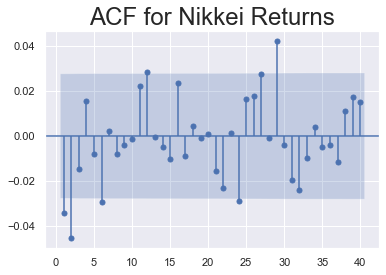

In [25]:
sgt.plot_acf(test_data.returns[1:], zero=False, lags=40)
plt.title('ACF for Nikkei Returns', Size=24)
plt.show()

### Autoregressive Model

In [26]:
model_ma_1 = ARMA(test_data.returns[1:], order=(1,0))
results_ma_1 = model_ma_1.fit()
print(results_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(1, 0)   Log Likelihood               -9071.571
Method:                       css-mle   S.D. of innovations              1.477
Date:                Wed, 17 Mar 2021   AIC                          18149.141
Time:                        21:50:59   BIC                          18168.701
Sample:                             0   HQIC                         18155.996
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0033      0.020      0.163      0.871      -0.036       0.043
ar.L1.returns    -0.0345      0.014     -2.442      0.015      -0.062      -0.007
                                    Root

In [27]:
model_ma_2 = ARMA(test_data.returns[1:], order=(2,0))
results_ma_2 = model_ma_2.fit()
print(results_ma_2.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(2, 0)   Log Likelihood               -9066.044
Method:                       css-mle   S.D. of innovations              1.476
Date:                Wed, 17 Mar 2021   AIC                          18140.089
Time:                        21:51:25   BIC                          18166.169
Sample:                             0   HQIC                         18149.228
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.019      0.169      0.866      -0.034       0.041
ar.L1.returns    -0.0361      0.014     -2.557      0.011      -0.064      -0.008
ar.L2.returns    -0.0469      0.014     

In [28]:
#LLR Test
def LLR_test(mod_1,mod_2, DF=1):
    #mod_1, mod_2: modelwe want to compare
    #Degree of Freedom
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR,DF).round(2)
    return p

In [29]:
print('LLR_Test : ' + str(LLR_test(model_ma_1,model_ma_2)))

LLR_Test : 0.0


In [30]:
model_ma_3 = ARMA(test_data.returns[1:], order=(3,0))
results_ma_3 = model_ma_3.fit()
print(results_ma_3.summary())
print('\n')
print('LLR_Test : ' + str(LLR_test(model_ma_2,model_ma_3)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(3, 0)   Log Likelihood               -9065.221
Method:                       css-mle   S.D. of innovations              1.476
Date:                Wed, 17 Mar 2021   AIC                          18140.442
Time:                        21:52:14   BIC                          18173.042
Sample:                             0   HQIC                         18151.867
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.019      0.171      0.864      -0.034       0.040
ar.L1.returns    -0.0369      0.014     -2.615      0.009      -0.065      -0.009
ar.L2.returns    -0.0476      0.014     

In [31]:
model_ma_4 = ARMA(test_data.returns[1:], order=(4,0))
results_ma_4 = model_ma_4.fit()
print(results_ma_4.summary())
print('\n')
print('LLR_Test : ' + str(LLR_test(model_ma_3,model_ma_4)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(4, 0)   Log Likelihood               -9064.846
Method:                       css-mle   S.D. of innovations              1.475
Date:                Wed, 17 Mar 2021   AIC                          18141.692
Time:                        21:52:38   BIC                          18180.812
Sample:                             0   HQIC                         18155.401
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.019      0.170      0.865      -0.034       0.041
ar.L1.returns    -0.0367      0.014     -2.599      0.009      -0.064      -0.009
ar.L2.returns    -0.0470      0.014     

In [32]:
model_ma_5 = ARMA(test_data.returns[1:], order=(5,0))
results_ma_5 = model_ma_5.fit()
print(results_ma_5.summary())
print('\n')
print('LLR_Test : ' + str(LLR_test(model_ma_4,model_ma_5)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(5, 0)   Log Likelihood               -9064.646
Method:                       css-mle   S.D. of innovations              1.475
Date:                Wed, 17 Mar 2021   AIC                          18143.293
Time:                        21:53:09   BIC                          18188.933
Sample:                             0   HQIC                         18159.287
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.019      0.171      0.864      -0.034       0.040
ar.L1.returns    -0.0366      0.014     -2.591      0.010      -0.064      -0.009
ar.L2.returns    -0.0472      0.014     

In [33]:
model_ma_6 = ARMA(test_data.returns[1:], order=(6,0))
results_ma_6 = model_ma_6.fit()
print(results_ma_6.summary())
print('\n')
print('LLR_Test : ' + str(LLR_test(model_ma_5,model_ma_6)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(6, 0)   Log Likelihood               -9062.478
Method:                       css-mle   S.D. of innovations              1.475
Date:                Wed, 17 Mar 2021   AIC                          18140.955
Time:                        21:53:48   BIC                          18193.115
Sample:                             0   HQIC                         18159.234
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.018      0.175      0.861      -0.033       0.039
ar.L1.returns    -0.0369      0.014     -2.610      0.009      -0.065      -0.009
ar.L2.returns    -0.0468      0.014     

In [34]:
model_ma_7 = ARMA(test_data.returns[1:], order=(7,0))
results_ma_7 = model_ma_7.fit()
print(results_ma_7.summary())
print('\n')
print('LLR_Test : ' + str(LLR_test(model_ma_6,model_ma_7)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(7, 0)   Log Likelihood               -9062.477
Method:                       css-mle   S.D. of innovations              1.475
Date:                Wed, 17 Mar 2021   AIC                          18142.954
Time:                        21:54:26   BIC                          18201.633
Sample:                             0   HQIC                         18163.517
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.018      0.175      0.861      -0.033       0.039
ar.L1.returns    -0.0369      0.014     -2.610      0.009      -0.065      -0.009
ar.L2.returns    -0.0468      0.014     

## Moving Average (MA)

In [35]:
#Model
model_ret_ma_1 = ARMA(test_data.returns[1:], order=(0,1))
results_ret_ma_1 = model_ret_ma_1.fit()
print(results_ret_ma_1.summary())

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(0, 1)   Log Likelihood               -9071.262
Method:                       css-mle   S.D. of innovations              1.477
Date:                Wed, 17 Mar 2021   AIC                          18148.524
Time:                        21:55:18   BIC                          18168.084
Sample:                             0   HQIC                         18155.379
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0033      0.020      0.163      0.870      -0.036       0.043
ma.L1.returns    -0.0381      0.015     -2.566      0.010      -0.067      -0.009
                                    Root

In [36]:
model_ret_ma_2 = ARMA(test_data.returns[1:], order=(0,2))
results_ret_ma_2 = model_ret_ma_2.fit()
print(results_ret_ma_2.summary())
print('\n')
print('LLR Test p-value = ' + str(LLR_test(model_ret_ma_1, model_ret_ma_2)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(0, 2)   Log Likelihood               -9065.894
Method:                       css-mle   S.D. of innovations              1.476
Date:                Wed, 17 Mar 2021   AIC                          18139.788
Time:                        21:55:34   BIC                          18165.868
Sample:                             0   HQIC                         18148.927
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.019      0.170      0.865      -0.034       0.041
ma.L1.returns    -0.0376      0.014     -2.668      0.008      -0.065      -0.010
ma.L2.returns    -0.0458      0.014     

In [37]:
model_ret_ma_3 = ARMA(test_data.returns[1:], order=(0,3))
results_ret_ma_3 = model_ret_ma_3.fit()
print(results_ret_ma_3.summary())
print('\n')
print('LLR Test p-value = ' + str(LLR_test(model_ret_ma_2, model_ret_ma_3)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(0, 3)   Log Likelihood               -9065.309
Method:                       css-mle   S.D. of innovations              1.476
Date:                Wed, 17 Mar 2021   AIC                          18140.618
Time:                        21:55:50   BIC                          18173.218
Sample:                             0   HQIC                         18152.042
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.019      0.172      0.863      -0.034       0.040
ma.L1.returns    -0.0366      0.014     -2.586      0.010      -0.064      -0.009
ma.L2.returns    -0.0456      0.014     

In [38]:
model_ret_ma_4 = ARMA(test_data.returns[1:], order=(0,4))
results_ret_ma_4 = model_ret_ma_4.fit()
print(results_ret_ma_4.summary())
print('\n')
print('LLR Test p-value = ' + str(LLR_test(model_ret_ma_3, model_ret_ma_4)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(0, 4)   Log Likelihood               -9064.934
Method:                       css-mle   S.D. of innovations              1.475
Date:                Wed, 17 Mar 2021   AIC                          18141.869
Time:                        21:56:08   BIC                          18180.989
Sample:                             0   HQIC                         18155.578
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.019      0.170      0.865      -0.034       0.041
ma.L1.returns    -0.0365      0.014     -2.584      0.010      -0.064      -0.009
ma.L2.returns    -0.0454      0.014     

In [39]:
model_ret_ma_5 = ARMA(test_data.returns[1:], order=(0,5))
results_ret_ma_5 = model_ret_ma_5.fit()
print(results_ret_ma_5.summary())
print('\n')
print('LLR Test p-value = ' + str(LLR_test(model_ret_ma_4, model_ret_ma_5)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(0, 5)   Log Likelihood               -9064.645
Method:                       css-mle   S.D. of innovations              1.475
Date:                Wed, 17 Mar 2021   AIC                          18143.290
Time:                        21:56:53   BIC                          18188.930
Sample:                             0   HQIC                         18159.284
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.019      0.172      0.864      -0.034       0.040
ma.L1.returns    -0.0373      0.014     -2.633      0.008      -0.065      -0.010
ma.L2.returns    -0.0452      0.014     

In [40]:
model_ret_ma_6 = ARMA(test_data.returns[1:], order=(0,6))
results_ret_ma_6 = model_ret_ma_6.fit()
print(results_ret_ma_6.summary())
print('\n')
print('LLR Test p-value = ' + str(LLR_test(model_ret_ma_5, model_ret_ma_6)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(0, 6)   Log Likelihood               -9062.481
Method:                       css-mle   S.D. of innovations              1.475
Date:                Wed, 17 Mar 2021   AIC                          18140.962
Time:                        21:57:18   BIC                          18193.122
Sample:                             0   HQIC                         18159.241
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.018      0.176      0.860      -0.033       0.039
ma.L1.returns    -0.0369      0.014     -2.611      0.009      -0.065      -0.009
ma.L2.returns    -0.0460      0.014     

In [41]:
model_ret_ma_7 = ARMA(test_data.returns[1:], order=(0,7))
results_ret_ma_7 = model_ret_ma_7.fit()
print(results_ret_ma_7.summary())
print('\n')
print('LLR Test p-value = ' + str(LLR_test(model_ret_ma_6, model_ret_ma_7)))

                              ARMA Model Results                              
Dep. Variable:                returns   No. Observations:                 5014
Model:                     ARMA(0, 7)   Log Likelihood               -9062.479
Method:                       css-mle   S.D. of innovations              1.475
Date:                Wed, 17 Mar 2021   AIC                          18142.958
Time:                        21:58:37   BIC                          18201.638
Sample:                             0   HQIC                         18163.522
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0032      0.018      0.176      0.860      -0.033       0.039
ma.L1.returns    -0.0369      0.014     -2.611      0.009      -0.065      -0.009
ma.L2.returns    -0.0460      0.014     

In [43]:
test_data['res_ret_ma_6'] = results_ret_ma_6.resid[:1]

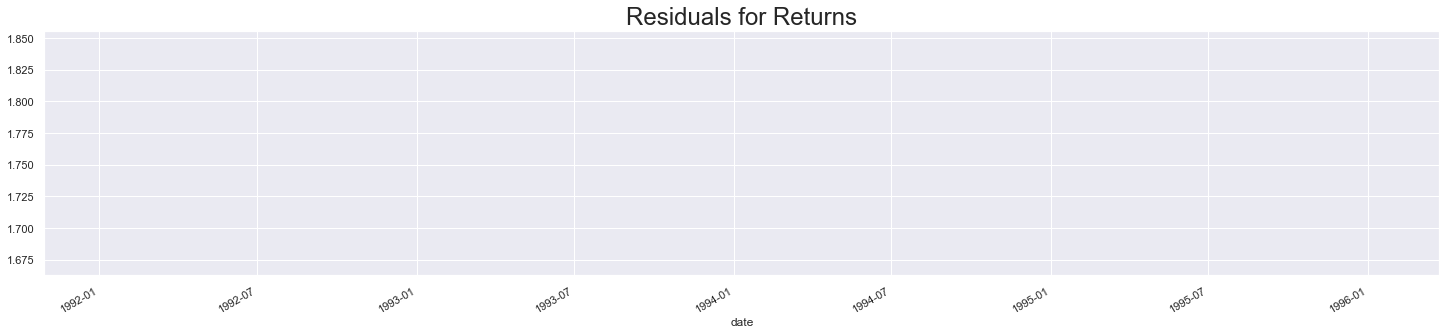

In [45]:
test_data.res_ret_ma_6.plot(figsize=(25,5))
plt.title('Residuals for Returns', size=24)
plt.show()

In [47]:
test_data.head(10)

,price,returns,res_ret_ma_8,res_ret_ma_6
date,,,,
1994-01-07,18124.01,NaN,NaN,NaN
1994-01-10,18443.44,1.762469,1.759246,1.759246
1994-01-11,18485.25,0.226693,NaN,NaN
1994-01-12,18793.88,1.669601,NaN,NaN
1994-01-13,18577.26,-1.152609,NaN,NaN
1994-01-14,18973.70,2.134007,NaN,NaN
1994-01-17,18725.37,-1.308812,NaN,NaN
1994-01-18,18514.55,-1.125852,NaN,NaN
1994-01-19,19039.40,2.834797,NaN,NaN
